In [2]:
# Interactive Analysis for high-resolution clustering use leiden

In [3]:
!python3 -m venv new_env
!source new_env/bin/activate
%pip install numpy==1.26
%pip install --upgrade scanpy
%pip install igraph
%pip install openpyxl
%pip install leidenalg
%pip install hdf5plugin


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is a

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
from tqdm import tqdm
import hdf5plugin
# Set random seed for reproducibility
np.random.seed(42)
meta_data = pd.read_excel("../../data/sea-ad_cohort_donor_metadata_072524.xlsx")
selected_samples = meta_data["Donor ID"][meta_data["Last CASI Score"] != np.nan]
print(f'{len(selected_samples)} donors remain.')
# Directory containing .h5ad files (update this path)
data_dir = "../data"
data_file = os.path.join(data_dir,"combined_corrected_data.h5ad")

84 donors remain.


In [5]:
import scanpy as sc
import numpy as np
from tqdm import tqdm


def process_combined_dataset(combined_file_path, meta_data):
    print("Loading combined dataset...")
    adata = sc.read_h5ad(combined_file_path)
    
    # Extract unique donor IDs from the combined dataset
    donor_ids = adata.obs['Donor ID'].unique()
    print(f"Found {len(donor_ids)} unique donors in the dataset")
    
    # Categorize donors based on cognitive status
    dementia_donors = []
    no_dementia_donors = []
    young_donors = []
    
    for donor_id in tqdm(donor_ids, desc="Categorizing donors"):
        # Get cognitive status for this donor from metadata
        status = meta_data[meta_data["Donor ID"]==donor_id]["Cognitive Status"].tolist()
        
        if len(status) > 1:
            print(f"Error: Multiple cognitive status entries for donor {donor_id}!")
            continue
        if len(status) == 0:
            # Assuming donors with no cognitive status are young reference donors
            young_donors.append(donor_id)
        elif status[0] == "Dementia":
            dementia_donors.append(donor_id)
        elif status[0] == 'No dementia':
            no_dementia_donors.append(donor_id)
        else:
            print(f"Error: Unknown Cognitive Status '{status[0]}' for donor {donor_id}!")
            continue
    
    print(f"Dementia: {len(dementia_donors)}, No dementia: {len(no_dementia_donors)}, Young: {len(young_donors)}")
    
  
    donor_groups = {
        'dementia': 
            dementia_donors
           
        ,
        'no_dementia': 
            no_dementia_donors
        ,
    
        'young': 
             young_donors
            
        
       
    }
    
    return adata, donor_groups

# Example usage
# combined_file_path = "path/to/combined_data.h5ad"
# meta_data = pd.read_csv("path/to/metadata.csv")  # Make sure to define or import meta_data
data_set,  donor_groups = process_combined_dataset(data_file, meta_data)

Loading combined dataset...
Found 84 unique donors in the dataset


Categorizing donors: 100%|██████████| 84/84 [00:00<00:00, 7112.58it/s]

Dementia: 42, No dementia: 42, Young: 0


In [8]:
import scanpy as sc
import numpy as np
import gc
from scanpy import logging
import warnings

def simulate_cluster_means(training_set, n_samples_per_donor_id, n_simulations, resolution=1.0, random_state=42):
    """
    Perform multiple simulations of sampling cells, clustering, and calculating cluster means.
    
    Parameters:
    -----------
    training_set : AnnData
        The training dataset containing cells from different donors
    n_samples_per_donor_id : int
        Number of cells to sample from each donor
    n_simulations : int
        Number of simulations to run
    resolution : float, default=1.0
        Resolution parameter for Leiden clustering
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    all_cluster_means : list
        List of cluster means for each simulation
        Each element is a dictionary with cluster ID as key and mean expression as value
    simulation_results : list
        List of dictionaries containing detailed results for each simulation
    """
    print(f"Starting {n_simulations} simulations with {n_samples_per_donor_id} samples per donor_id")
    
    # Get unique donor ids
    donor_ids = training_set.obs['Donor ID'].unique().tolist()
    print(f"Found {len(donor_ids)} unique donor ID")
    
    # Store all cluster means from all simulations
    all_cluster_means = []
    simulation_results = []
    
    for sim in range(n_simulations):
        np.random.seed(random_state + sim)  # Different seed for each simulation
        
        # Sample cells from each donor
        sampled_indices = []
        for donor_id in donor_ids:
            # Get indices of cells with this donor
            sample_indices = np.where(training_set.obs['Donor ID'] == donor_id)[0]
            
            # Sample from this group
            if len(sample_indices) > n_samples_per_donor_id:
                # If enough cells, sample without replacement
                selected_indices = np.random.choice(sample_indices, n_samples_per_donor_id, replace=False)
            else:
                # If not enough cells, sample with replacement to reach target count
                selected_indices = np.random.choice(sample_indices, n_samples_per_donor_id, replace=True)
                
            sampled_indices.extend(selected_indices)
        
        # Create a view (not a copy) of the AnnData object with the sampled cells
        adata_sample = training_set[sampled_indices]
        
        # PCA - necessary for clustering
        sc.tl.pca(adata_sample)
        
        # Compute neighborhood graph
        sc.pp.neighbors(adata_sample)
        
        # Run Leiden clustering
        sc.tl.leiden(adata_sample, resolution=resolution, random_state=random_state+sim, flavor="igraph", n_iterations=2, directed=False)
        
        # Calculate cluster means efficiently
        clusters = adata_sample.obs['leiden'].unique()
        cluster_means = []
        
        for cluster in clusters:
            # Get cells in this cluster using boolean indexing
            cluster_mask = adata_sample.obs['leiden'] == cluster
            cluster_cells = adata_sample[cluster_mask]
            
            # Calculate mean expression efficiently for sparse matrices
            if hasattr(cluster_cells.X, "toarray"):
                # For sparse matrices, compute mean without full conversion to dense
                mean_expression = np.array(cluster_cells.X.mean(axis=0)).flatten()
            else:
                mean_expression = np.mean(cluster_cells.X, axis=0)
                
                # Ensure it's a 1D array
                if mean_expression.ndim > 1:
                    mean_expression = mean_expression.flatten()
                    
            cluster_means.append(mean_expression)
        
        # Store results - only store the means, not the full data
        all_cluster_means.extend(cluster_means)
        
        # Store minimal information for this simulation to save memory
        simulation_info = {
            'simulation_id': sim,
            'optimal_k': len(clusters),
            'clusters': list(clusters),
            'cluster_sizes': {cluster: np.sum(adata_sample.obs['leiden'] == cluster) for cluster in clusters},
            # Don't store indices or full means again to save memory
        }
        
        simulation_results.append(simulation_info)
        
        print(f"Simulation {sim+1}/{n_simulations} complete: {len(clusters)} clusters identified")
        
        # Force garbage collection to free memory after each simulation
        gc.collect()
    
    print(f"All {n_simulations} simulations completed")
    
    return all_cluster_means, simulation_results

# Example usage:
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
n_samples_per_donor_id = 2000  # Sample cells from each donor
n_simulations = 10  # Run 10 simulations
cluster_means, simulation_results = simulate_cluster_means(data_set, n_samples_per_donor_id, n_simulations)

Starting 10 simulations with 2000 samples per donor_id
Found 84 unique donor ID


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 1/10 complete: 40 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 2/10 complete: 40 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 3/10 complete: 40 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 4/10 complete: 40 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 5/10 complete: 36 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 6/10 complete: 41 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 7/10 complete: 39 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 8/10 complete: 40 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 9/10 complete: 38 clusters identified


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Simulation 10/10 complete: 39 clusters identified
All 10 simulations completed


In [9]:
# Convert cluster means to a numpy array (leave out cluster labels)
cluster_means_array = np.array(cluster_means)
print(cluster_means_array.shape)

(393, 2000)


In [1]:

## cluster of cluster_mean
import importlib
import matplotlib.pyplot as plt
from my_kmeans import kmeans
importlib.reload(kmeans)
from sklearn.metrics import silhouette_score
# ------------------------------------------
# 1. Compute WCSS for different K values
# ------------------------------------------
silhouette_scores = []
wcss_values = []
K_range = range(3, 50)  # Test cluster numbers from 1 to 10
for k in tqdm(K_range,desc = "Processing"):
    _, wcss, labels = kmeans.k_means(np.array(cluster_means_array.T), k, max_iterations= 1000, random_state=42)
    wcss_values.append(wcss)  # Inertia is the WCSS (sum of squared distances)
    score = silhouette_score(cluster_means_array, labels)
    silhouette_scores.append(score)

# ------------------------------------------
# 2. Plot WCSS vs. Number of Clusters (Elbow Method)
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Increase figure size for clarity
plt.plot(K_range, np.log(wcss_values), marker='o', linestyle='-', color='b', markersize=8, linewidth=2, label='WCSS (Log Scale)') 
plt.xlabel("Number of Clusters (K)", fontsize=14)
plt.ylabel("Log Within-Cluster Sum of Squares (WCSS)", fontsize=14)
plt.title("Elbow Method for Optimal K", fontsize=16)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# ------------------------------------------
# Plotting the silhouette scores
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Increase figure size for clarity
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='g', markersize=8, linewidth=2, label='Silhouette Scores')
plt.title('Silhouette Scores for Different K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


NameError: name 'tqdm' is not defined

In [25]:

# (2000 features, 28 clusters)
def create_cluster_means_dict(overall_cluster_means, feature_names=None):
    """
    Convert a cluster means matrix to a dictionary format required by label_dataset_with_clusters.
    
    Parameters:
    -----------
    overall_cluster_means : numpy.ndarray
        2D array of shape (n_features, n_clusters) or (n_clusters, n_features)
        Contains the mean expression values for each cluster
    feature_names : list, optional
        List of feature names. If None, feature indices will be used.
        
    Returns:
    --------
    cluster_means_dict : dict
        Dictionary with cluster IDs as keys and mean expression vectors as values
    """
    # Determine the shape and orientation of the matrix
    shape = overall_cluster_means.shape
    means_array = overall_cluster_means.T
    n_clusters = shape[1]

    
    # Create the dictionary
    cluster_means_dict = {}
    for i in range(n_clusters):
        # Use string keys to match the expected format
        cluster_id = str(i)
        cluster_means_dict[cluster_id] = means_array[i]
    
    return cluster_means_dict

optimal_k_fine = np.argmax(np.array(silhouette_scores)) + K_range[0]
print(f"Set k = {optimal_k_fine}.")
overall_cluster_means_fine, _, _ = kmeans.k_means(np.array(cluster_means_array.T), optimal_k_fine, max_iterations= 1000, random_state=42)
# Convert overall_cluster_means to the dictionary format
cluster_means_dict_fine = create_cluster_means_dict(overall_cluster_means_fine)
optimal_k_coarse = 3
print(f"Set k = {optimal_k_coarse}.")
overall_cluster_means_coarse, _, _ = kmeans.k_means(np.array(cluster_means_array.T), optimal_k_coarse, max_iterations= 1000, random_state=42)
# Convert overall_cluster_means to the dictionary format
cluster_means_dict_coarse = create_cluster_means_dict(overall_cluster_means_coarse)





Set k = 35.
Set k = 3.


Analyzing stability of 43 clusters with 2000 features...
Performing original clustering...
Original clustering completed:
  - Inertia: 197549.00
  - Silhouette score: 0.0711
Performing dimensionality reduction for visualization...
  - Generating PCA visualization...
  - Generating t-SNE visualization...
  - Generating UMAP visualization...


/opt/homebrew/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating silhouette values...
Performing bootstrap stability analysis with 30 resamples...
  - Bootstrap 1/30...
  - Bootstrap 2/30...
  - Bootstrap 3/30...
  - Bootstrap 4/30...
  - Bootstrap 5/30...
  - Bootstrap 6/30...
  - Bootstrap 7/30...
  - Bootstrap 8/30...
  - Bootstrap 9/30...
  - Bootstrap 10/30...
  - Bootstrap 11/30...
  - Bootstrap 12/30...
  - Bootstrap 13/30...
  - Bootstrap 14/30...
  - Bootstrap 15/30...
  - Bootstrap 16/30...
  - Bootstrap 17/30...
  - Bootstrap 18/30...
  - Bootstrap 19/30...
  - Bootstrap 20/30...
  - Bootstrap 21/30...
  - Bootstrap 22/30...
  - Bootstrap 23/30...
  - Bootstrap 24/30...
  - Bootstrap 25/30...
  - Bootstrap 26/30...
  - Bootstrap 27/30...
  - Bootstrap 28/30...
  - Bootstrap 29/30...
  - Bootstrap 30/30...
Generating stability map from cross-validation...
  - Cross-validation fold 1/10...
  - Cross-validation fold 2/10...
  - Cross-validation fold 3/10...
  - Cross-validation fold 4/10...
  - Cross-validation fold 5/10...
  - C

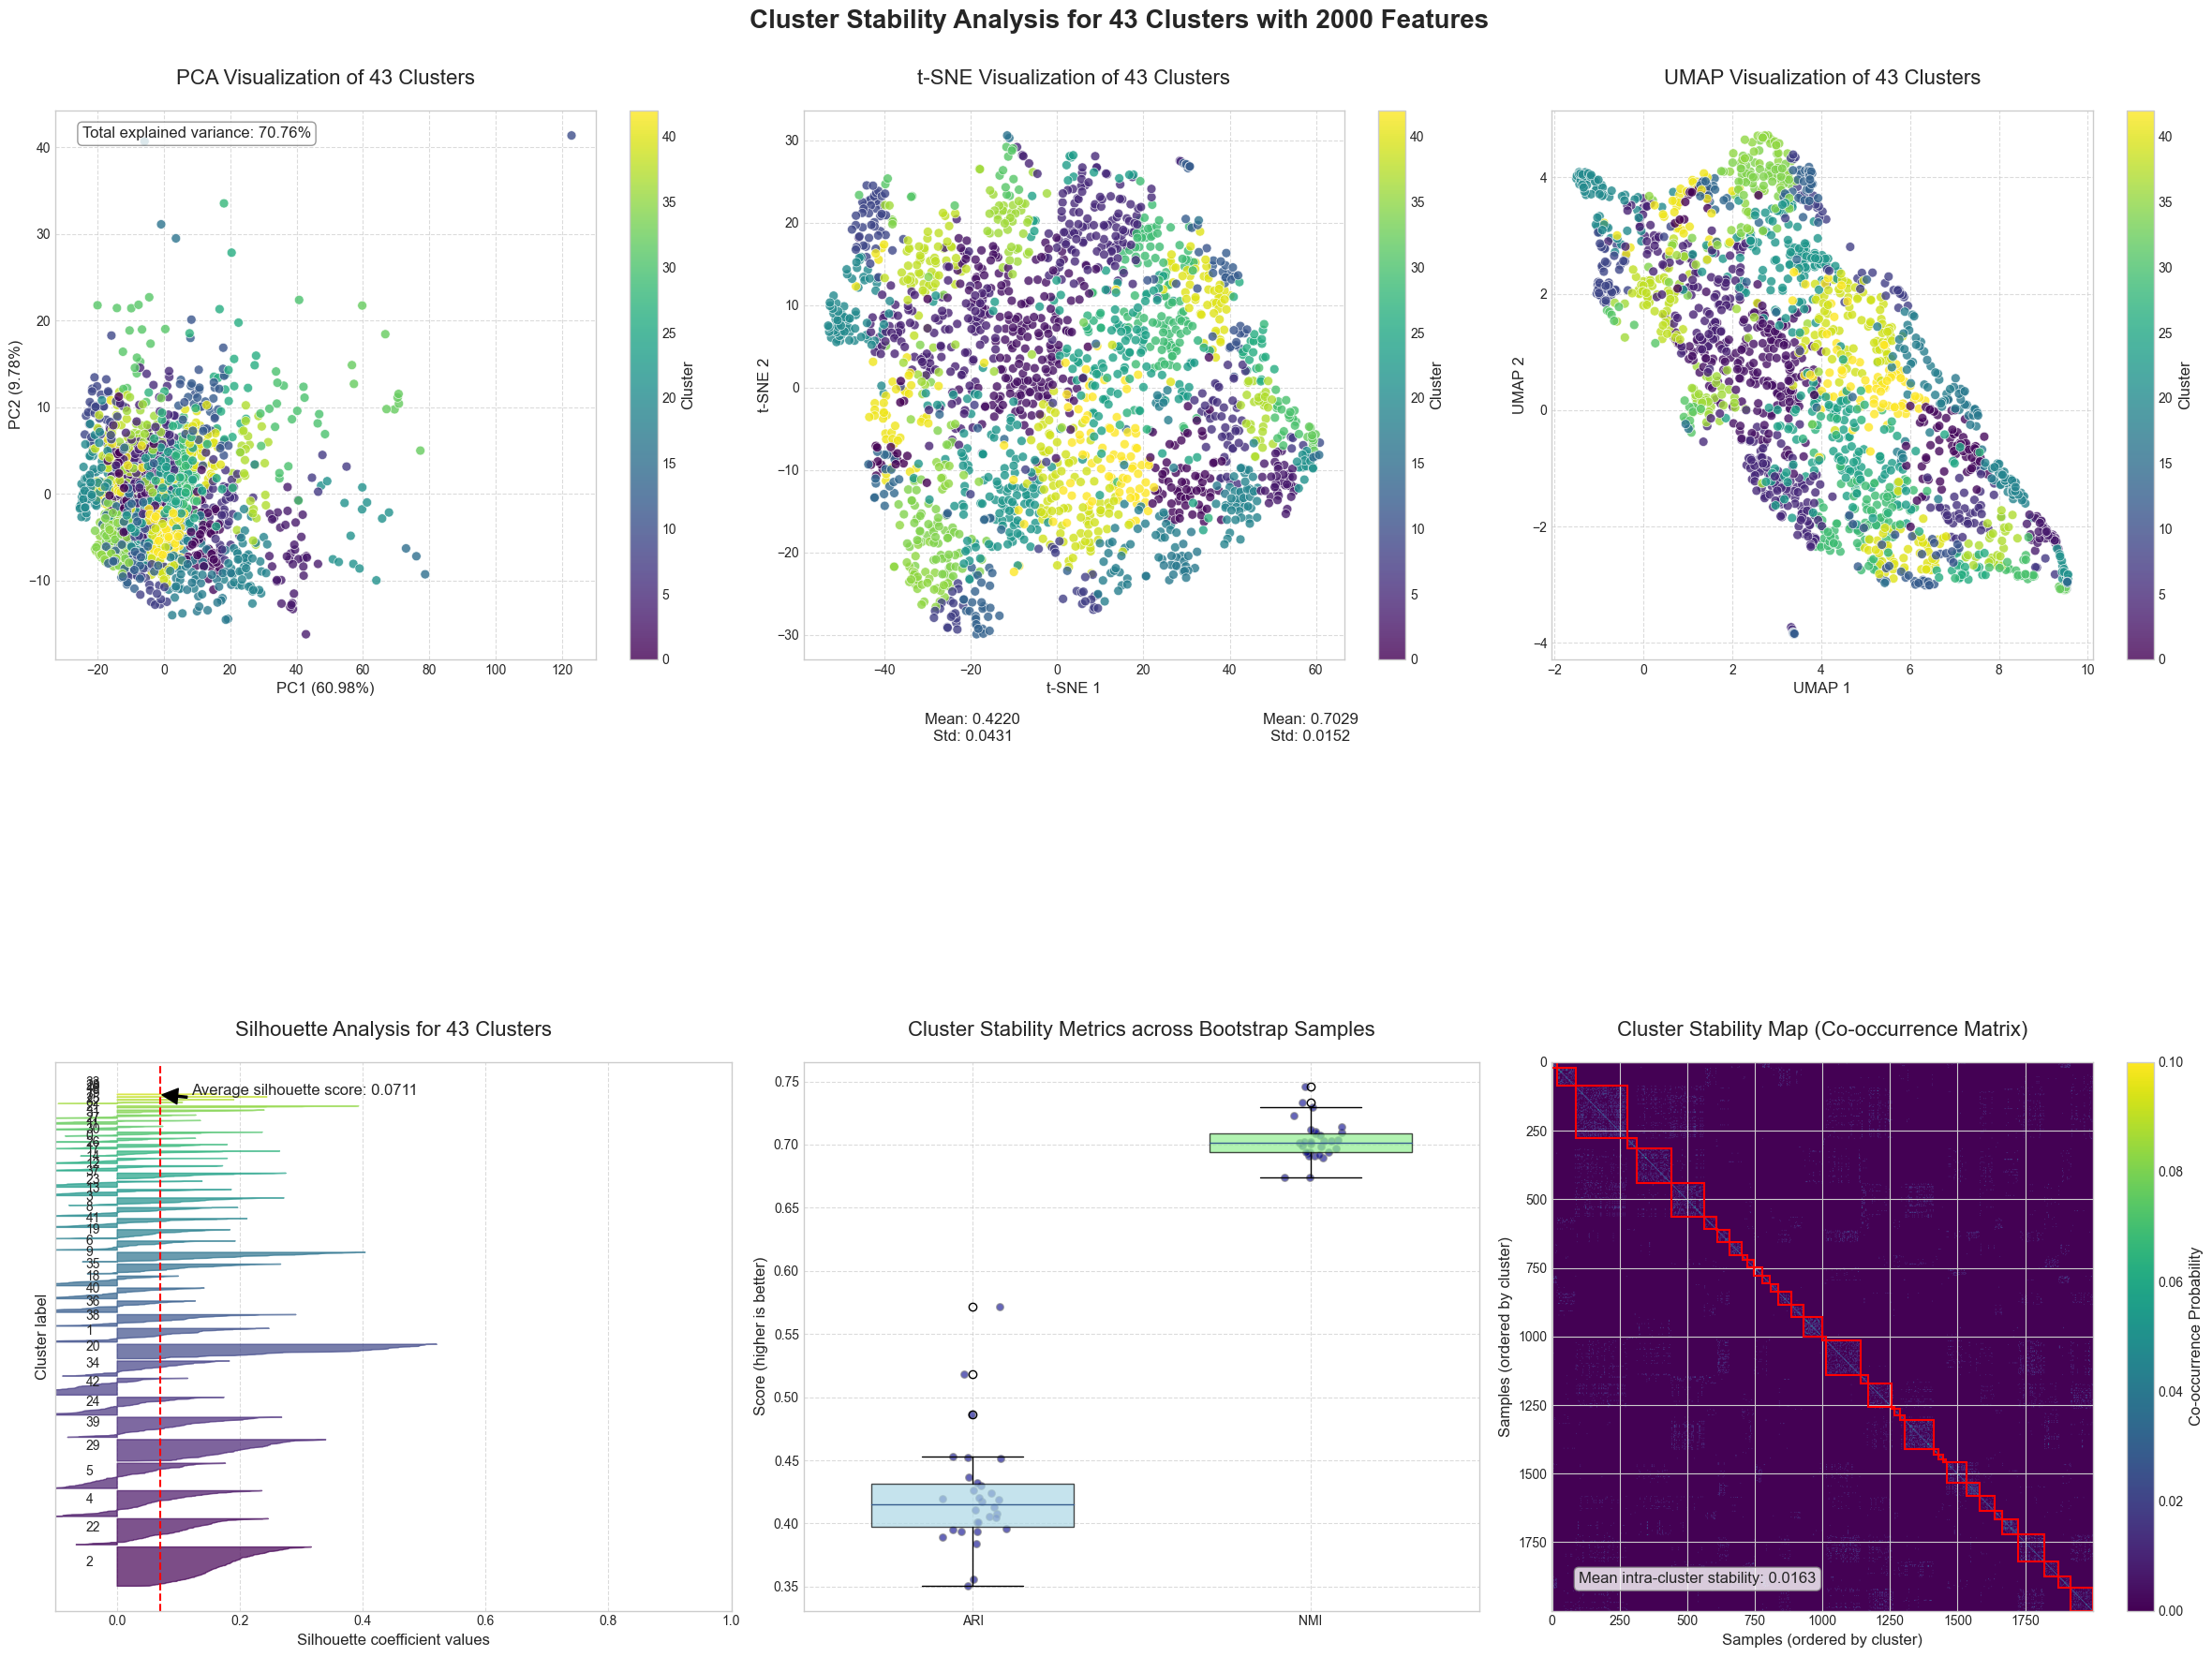


Cluster Stability Summary:
Silhouette Score: 0.0711
Inertia: 197549.00
Adjusted Rand Index (ARI): 0.4220 ± 0.0431
Normalized Mutual Information (NMI): 0.7029 ± 0.0152
Mean Intra-cluster Stability: 0.0163
Overall Cluster Stability Assessment: Moderate


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import KFold

# Set the style for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def analyze_cluster_stability(cluster_means_array, optimal_k=28, n_features=2000, max_iterations=1000, random_state=42, n_bootstraps=30, sample_fraction=0.8):
    """
    Analyze and visualize the stability of clusters.
    
    Parameters:
    ----------
    cluster_means_array : numpy.ndarray
        2D array of shape (n_features, n_samples) used for clustering
    optimal_k : int
        Number of clusters to use
    n_features : int
        Number of features used in clustering
    max_iterations : int
        Maximum number of iterations for k-means
    random_state : int
        Random seed for reproducibility
    n_bootstraps : int
        Number of bootstrap samples to generate
    sample_fraction : float
        Fraction of data to sample in each bootstrap
        
    Returns:
    -------
    stability_metrics : dict
        Dictionary containing stability metrics
    """
    print(f"Analyzing stability of {optimal_k} clusters with {n_features} features...")
    
    # 1. Original clustering result
    print("Performing original clustering...")
    from sklearn.cluster import KMeans
    
    # Create a copy of the data (transpose if needed based on your data structure)
    data = np.array(cluster_means_array.T)  # Shape should be (n_samples, n_features)
    
    # Standardize the data for better clustering
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, max_iter=max_iterations, random_state=random_state, n_init=10)
    original_labels = kmeans.fit_predict(data_scaled)
    original_centers = kmeans.cluster_centers_
    
    # Calculate cluster metrics
    original_inertia = kmeans.inertia_
    original_silhouette = silhouette_score(data_scaled, original_labels)
    
    print(f"Original clustering completed:")
    print(f"  - Inertia: {original_inertia:.2f}")
    print(f"  - Silhouette score: {original_silhouette:.4f}")
    
    # 2. Dimensionality reduction for visualization
    print("Performing dimensionality reduction for visualization...")
    
    # Prepare a figure with multiple subplots
    fig = plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
    
    # 2.1 PCA visualization
    print("  - Generating PCA visualization...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled)
    
    ax1 = plt.subplot(gs[0, 0])
    scatter = ax1.scatter(pca_result[:, 0], pca_result[:, 1], c=original_labels, cmap='viridis', 
                         s=50, alpha=0.8, edgecolors='w', linewidths=0.5)
    ax1.set_title(f'PCA Visualization of {optimal_k} Clusters', fontsize=16, pad=20)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Cluster', fontsize=12)
    
    # Add explained variance annotation
    total_var = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
    ax1.annotate(f'Total explained variance: {total_var*100:.2f}%',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                fontsize=12)
    
    # 2.2 t-SNE visualization
    print("  - Generating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=min(30, len(data_scaled)-1))
    tsne_result = tsne.fit_transform(data_scaled)
    
    ax2 = plt.subplot(gs[0, 1])
    scatter = ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], c=original_labels, cmap='viridis', 
                         s=50, alpha=0.8, edgecolors='w', linewidths=0.5)
    ax2.set_title(f't-SNE Visualization of {optimal_k} Clusters', fontsize=16, pad=20)
    ax2.set_xlabel('t-SNE 1', fontsize=12)
    ax2.set_ylabel('t-SNE 2', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Cluster', fontsize=12)
    
    # 2.3 UMAP visualization
    print("  - Generating UMAP visualization...")
    reducer = umap.UMAP(random_state=random_state, min_dist=0.1, n_neighbors=min(15, len(data_scaled)-1))
    umap_result = reducer.fit_transform(data_scaled)
    
    ax3 = plt.subplot(gs[0, 2])
    scatter = ax3.scatter(umap_result[:, 0], umap_result[:, 1], c=original_labels, cmap='viridis', 
                         s=50, alpha=0.8, edgecolors='w', linewidths=0.5)
    ax3.set_title(f'UMAP Visualization of {optimal_k} Clusters', fontsize=16, pad=20)
    ax3.set_xlabel('UMAP 1', fontsize=12)
    ax3.set_ylabel('UMAP 2', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Cluster', fontsize=12)
    
    # 3. Calculate silhouette values for each sample
    print("Calculating silhouette values...")
    silhouette_vals = silhouette_samples(data_scaled, original_labels)
    
    # Create a silhouette plot
    ax4 = plt.subplot(gs[1, 0])
    y_lower = 10
    
    # Sort clusters by size
    cluster_sizes = {}
    for i in range(optimal_k):
        cluster_sizes[i] = sum(original_labels == i)
    
    sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
    sorted_cluster_indices = [x[0] for x in sorted_clusters]
    
    cluster_colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
    
    for i, cluster_idx in enumerate(sorted_cluster_indices):
        # Aggregate silhouette scores for samples in this cluster
        ith_cluster_silhouette_vals = silhouette_vals[original_labels == cluster_idx]
        ith_cluster_silhouette_vals.sort()
        
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cluster_colors[i]
        ax4.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with cluster numbers
        ax4.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster_idx))
        
        # Compute new y_lower for next plot
        y_lower = y_upper + 10
    
    ax4.set_title(f'Silhouette Analysis for {optimal_k} Clusters', fontsize=16, pad=20)
    ax4.set_xlabel('Silhouette coefficient values', fontsize=12)
    ax4.set_ylabel('Cluster label', fontsize=12)
    
    # The vertical line for average silhouette score of all samples
    ax4.axvline(x=original_silhouette, color="red", linestyle="--")
    ax4.annotate(f'Average silhouette score: {original_silhouette:.4f}',
                xy=(original_silhouette, y_lower * 0.98),
                xytext=(original_silhouette + 0.05, y_lower * 0.98),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=12)
    
    ax4.set_yticks([])  # Clear the yaxis labels / ticks
    ax4.set_xlim([-0.1, 1])
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Perform bootstrap stability analysis
    print(f"Performing bootstrap stability analysis with {n_bootstraps} resamples...")
    
    # Initialize arrays to store bootstrap results
    bootstrap_labels = []
    bootstrap_silhouettes = []
    bootstrap_inertias = []
    ari_scores = []
    nmi_scores = []
    
    n_samples = data_scaled.shape[0]
    sample_size = int(n_samples * sample_fraction)
    
    for i in range(n_bootstraps):
        print(f"  - Bootstrap {i+1}/{n_bootstraps}...")
        
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=sample_size, replace=True)
        bootstrap_data = data_scaled[bootstrap_indices]
        
        # Run k-means on bootstrap sample
        kmeans_bootstrap = KMeans(n_clusters=optimal_k, max_iter=max_iterations, random_state=random_state, n_init=10)
        bootstrap_label = kmeans_bootstrap.fit_predict(bootstrap_data)
        bootstrap_labels.append(bootstrap_label)
        
        # Calculate metrics for this bootstrap
        bootstrap_inertias.append(kmeans_bootstrap.inertia_)
        
        # Only calculate silhouette if we have at least 2 samples in each cluster
        cluster_sizes = np.bincount(bootstrap_label)
        if np.all(cluster_sizes >= 2):
            bootstrap_silhouettes.append(silhouette_score(bootstrap_data, bootstrap_label))
        else:
            bootstrap_silhouettes.append(np.nan)
        
        # For stability metrics, we need to compare with original labels
        # but only for the sampled points
        original_subset = original_labels[bootstrap_indices]
        
        # Calculate ARI (Adjusted Rand Index)
        ari = adjusted_rand_score(original_subset, bootstrap_label)
        ari_scores.append(ari)
        
        # Calculate NMI (Normalized Mutual Information)
        nmi = normalized_mutual_info_score(original_subset, bootstrap_label)
        nmi_scores.append(nmi)
    
    # 5. Calculate stability metrics
    ari_mean = np.mean(ari_scores)
    ari_std = np.std(ari_scores)
    nmi_mean = np.mean(nmi_scores)
    nmi_std = np.std(nmi_scores)
    
    # Create stability metrics box plot
    ax5 = plt.subplot(gs[1, 1])
    
    stability_data = [ari_scores, nmi_scores]
    box = ax5.boxplot(stability_data, patch_artist=True, widths=0.6, labels=['ARI', 'NMI'])
    
    # Fill boxes with colors
    box_colors = ['lightblue', 'lightgreen']
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add scatter points for individual bootstrap samples
    for i, data_points in enumerate(stability_data):
        # Spread points horizontally
        x = np.random.normal(i+1, 0.05, size=len(data_points))
        ax5.scatter(x, data_points, alpha=0.6, s=30, edgecolors='gray', color='darkblue')
    
    ax5.set_title('Cluster Stability Metrics across Bootstrap Samples', fontsize=16, pad=20)
    ax5.set_ylabel('Score (higher is better)', fontsize=12)
    ax5.grid(True, linestyle='--', alpha=0.7)
    
    # Annotate with mean values
    ax5.text(1, 1.02, f'Mean: {ari_mean:.4f}\nStd: {ari_std:.4f}', 
             horizontalalignment='center', fontsize=12)
    ax5.text(2, 1.02, f'Mean: {nmi_mean:.4f}\nStd: {nmi_std:.4f}', 
             horizontalalignment='center', fontsize=12)
    
    # 6. Stability map - Cross-validation analysis
    print("Generating stability map from cross-validation...")
    
    ax6 = plt.subplot(gs[1, 2])
    
    # Calculate co-occurrence matrix via 10-fold cross-validation
    k_fold = KFold(n_splits=10, shuffle=True, random_state=random_state)
    n_fold = 0
    
    # Initialize co-occurrence matrix
    co_matrix = np.zeros((n_samples, n_samples))
    
    for train_idx, test_idx in k_fold.split(data_scaled):
        n_fold += 1
        print(f"  - Cross-validation fold {n_fold}/10...")
        
        # Train a clustering model on the training set
        kmeans_cv = KMeans(n_clusters=optimal_k, max_iter=max_iterations, random_state=random_state, n_init=10)
        kmeans_cv.fit(data_scaled[train_idx])
        
        # Apply to test set
        test_labels = kmeans_cv.predict(data_scaled[test_idx])
        
        # Update co-occurrence matrix for test indices
        for i, idx_i in enumerate(test_idx):
            for j, idx_j in enumerate(test_idx):
                if test_labels[i] == test_labels[j]:
                    co_matrix[idx_i, idx_j] += 1
    
    # Normalize by number of folds
    co_matrix = co_matrix / 10.0
    
    # Reorder co-occurrence matrix by cluster
    ordered_indices = np.argsort(original_labels)
    co_matrix_ordered = co_matrix[ordered_indices, :][:, ordered_indices]
    
    # Create a mask to highlight cluster boundaries
    cluster_boundaries = []
    current_cluster = original_labels[ordered_indices[0]]
    last_idx = 0
    
    for i, idx in enumerate(ordered_indices):
        if original_labels[idx] != current_cluster:
            cluster_boundaries.append((last_idx, i-1))
            current_cluster = original_labels[idx]
            last_idx = i
    
    # Add the last cluster
    cluster_boundaries.append((last_idx, len(ordered_indices)-1))
    
    # Plot heatmap
    im = ax6.imshow(co_matrix_ordered, cmap='viridis', aspect='auto')
    
    # Draw rectangles around clusters
    for start, end in cluster_boundaries:
        rect = plt.Rectangle((start-0.5, start-0.5), end-start+1, end-start+1, 
                            fill=False, edgecolor='red', linewidth=1.5)
        ax6.add_patch(rect)
    
    ax6.set_title('Cluster Stability Map (Co-occurrence Matrix)', fontsize=16, pad=20)
    ax6.set_xlabel('Samples (ordered by cluster)', fontsize=12)
    ax6.set_ylabel('Samples (ordered by cluster)', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax6)
    cbar.set_label('Co-occurrence Probability', fontsize=12)
    
    # Add annotation with overall stability
    mean_co_occurrence = np.mean([co_matrix_ordered[start:end+1, start:end+1].mean() 
                                 for start, end in cluster_boundaries])
    
    ax6.annotate(f'Mean intra-cluster stability: {mean_co_occurrence:.4f}',
                xy=(0.05, 0.05), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.suptitle(f'Cluster Stability Analysis for {optimal_k} Clusters with {n_features} Features', 
                fontsize=20, y=0.98, fontweight='bold')
    plt.subplots_adjust(top=0.92)
    
    plt.savefig('cluster_stability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return stability metrics
    stability_metrics = {
        'silhouette_score': original_silhouette,
        'inertia': original_inertia,
        'ari_mean': ari_mean,
        'ari_std': ari_std,
        'nmi_mean': nmi_mean,
        'nmi_std': nmi_std,
        'mean_co_occurrence': mean_co_occurrence
    }
    
    # Print stability summary
    print("\nCluster Stability Summary:")
    print(f"Silhouette Score: {original_silhouette:.4f}")
    print(f"Inertia: {original_inertia:.2f}")
    print(f"Adjusted Rand Index (ARI): {ari_mean:.4f} ± {ari_std:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_mean:.4f} ± {nmi_std:.4f}")
    print(f"Mean Intra-cluster Stability: {mean_co_occurrence:.4f}")
    
    if ari_mean > 0.8 and nmi_mean > 0.8:
        stability_assessment = "Excellent"
    elif ari_mean > 0.6 and nmi_mean > 0.6:
        stability_assessment = "Good"
    elif ari_mean > 0.4 and nmi_mean > 0.4:
        stability_assessment = "Moderate"
    else:
        stability_assessment = "Poor"
    
    print(f"Overall Cluster Stability Assessment: {stability_assessment}")
    
    return stability_metrics

# Example usage:
# Replace this with actual data loading and processing
cluster_means_array = cluster_means_array
stability_metrics = analyze_cluster_stability(cluster_means_array, optimal_k=43, n_features=2000)

In [27]:
from scipy.spatial.distance import cdist
import scanpy as sc
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

def label_dataset_with_clusters(dataset, cluster_means_dict, output_path=None):
    """
    Label a dataset based on similarity to pre-calculated cluster means.
    
    Parameters:
    -----------
    dataset : AnnData or str
        The AnnData object to label or path to h5ad file.
    cluster_means_dict : dict
        Dictionary with cluster IDs as keys and mean expression vectors as values.
    output_path : str, optional
        Path to save the resulting DataFrame. If None, only returns the DataFrame.
        
    Returns:
    --------
    patient_cluster_expr_df : pandas.DataFrame
        DataFrame containing sample IDs, cluster assignments, and mean expression values.
    """
    print("Starting dataset labeling based on cluster similarity...")
    
    # Convert cluster means dictionary to array for faster distance calculation
    cluster_ids = list(cluster_means_dict.keys())
    cluster_means_array = np.array([cluster_means_dict[cluster_id] for cluster_id in cluster_ids])
    
    # Initialize DataFrame and dictionary for cognitive status
    patient_cluster_expr_df = pd.DataFrame()
    sample_status = {}
    
    # Load the dataset if a path is provided
    if isinstance(dataset, str):
        print(f"Loading dataset from {dataset}")
        adata = sc.read_h5ad(dataset)
    else:
        adata = dataset
        
    # Get unique sample IDs
    if 'Donor ID' not in adata.obs.columns:
        print("Warning: 'Donor ID' column not found. Using first available sample ID for all cells.")
        # Extract a sample ID if available in the file name or metadata
        if hasattr(adata, 'filename') and adata.filename is not None:
            donor_id = adata.filename.split('/')[-1].split('.')[0]
        else:
            donor_id = "unknown_donor"
        adata.obs['Donor ID'] = donor_id
    
    donor_ids = adata.obs['Donor ID'].unique()
    print(f"Found {len(donor_ids)} unique Donor IDs")
    
    # Dictionary to track cell counts per donor and cluster
    donor_cluster_counts = {donor_id: {} for donor_id in donor_ids}
    
    # Process each sample separately to save memory
    for donor_id in tqdm(donor_ids, desc="Processing samples"):
        # Subset to the current sample
        sample_mask = adata.obs['Donor ID'] == donor_id
        sample_data = adata[sample_mask].copy()  # Explicitly create a copy to avoid ImplicitModificationWarning
        
        # Store cognitive status if available
        if 'Cognitive Status' in sample_data.obs.columns:
            sample_status[donor_id] = sample_data.obs['Cognitive Status'].iloc[0]
        
        # Convert sparse matrix to dense for distance calculation if needed
        X = sample_data.X
        if hasattr(X, "toarray"):
            # For larger matrices, process in batches to avoid memory issues
            batch_size = 1000  # Adjust based on available memory
            n_cells = X.shape[0]
            sample_data.obs['leiden'] = np.zeros(n_cells, dtype=str)  # Change to string type for cluster IDs
            
            for batch_start in range(0, n_cells, batch_size):
                batch_end = min(batch_start + batch_size, n_cells)
                batch_X = X[batch_start:batch_end].toarray()
                
                # Calculate distances and assign clusters
                distances = cdist(batch_X, cluster_means_array, metric='euclidean')
                cluster_assignments = np.argmin(distances, axis=1)
                
                # Convert numeric indices to original cluster IDs
                sample_data.obs.iloc[batch_start:batch_end, 
                                    sample_data.obs.columns.get_loc('leiden')] = [
                    cluster_ids[idx] for idx in cluster_assignments
                ]
                
                # Free memory
                del batch_X, distances, cluster_assignments
                gc.collect()
        else:
            # For small or already dense matrices
            distances = cdist(X, cluster_means_array, metric='euclidean')
            cluster_assignments = np.argmin(distances, axis=1)
            sample_data.obs['leiden'] = [cluster_ids[idx] for idx in cluster_assignments]
        
        # Count cells in each cluster for this donor
        cluster_counts = sample_data.obs['leiden'].value_counts().to_dict()
        donor_cluster_counts[donor_id] = cluster_counts
        
        # Compute and store mean expression per cluster
        rows = []
        for cluster in sample_data.obs['leiden'].unique():
            cluster_cells = sample_data[sample_data.obs['leiden'] == cluster]
            
            # Efficiently compute mean expression
            if hasattr(cluster_cells.X, "toarray"):
                mean_expr = np.array(cluster_cells.X.mean(axis=0)).flatten()
            else:
                mean_expr = np.mean(cluster_cells.X, axis=0)
                if mean_expr.ndim > 1:
                    mean_expr = mean_expr.flatten()
            
            # Create a dictionary for the current sample and cluster
            row_dict = {'Donor ID': donor_id, 'cluster': cluster}
            
            # Store the mean expression vector as a column
            row_dict['mean_expression'] = mean_expr.tolist()
            
            # Count cells in this cluster for this donor
            row_dict['cell_count'] = len(cluster_cells)
            
            # Add percent of cells in this cluster for this donor
            row_dict['percent_cells'] = (len(cluster_cells) / len(sample_data)) * 100
            
            rows.append(row_dict)
        
        # Append the results for this sample to the main DataFrame
        sample_df = pd.DataFrame(rows)
        patient_cluster_expr_df = pd.concat([patient_cluster_expr_df, sample_df], ignore_index=True)
        
        # Clear memory
        del sample_data, rows, sample_df
        gc.collect()
    
    # Add cognitive status to the final DataFrame if available
    if sample_status:
        patient_cluster_expr_df['Cognitive Status'] = patient_cluster_expr_df['Donor ID'].map(sample_status)
    
    # Create a separate DataFrame with complete cell count matrix
    # Fill in zeros for missing donor-cluster combinations
    cell_count_rows = []
    for donor_id in donor_ids:
        for cluster_id in cluster_ids:
            count = donor_cluster_counts[donor_id].get(cluster_id, 0)
            cell_count_rows.append({
                'Donor ID': donor_id,
                'cluster': cluster_id,
                'cell_count': count
            })
    
    cell_count_df = pd.DataFrame(cell_count_rows)
    
    # Save the cell count matrix if output path is provided
    if output_path:
        cell_count_output = output_path.replace('.csv', '_cell_counts.csv')
        print(f"Saving cell count matrix to {cell_count_output}")
        cell_count_df.to_csv(cell_count_output, index=False)
        
        # Create a pivot table for easier visualization
        pivot_df = cell_count_df.pivot(index='Donor ID', columns='cluster', values='cell_count').fillna(0)
        pivot_output = output_path.replace('.csv', '_cell_counts_pivot.csv')
        pivot_df.to_csv(pivot_output)
        print(f"Saved pivot table to '{pivot_output}'")
    
    # Save results if output path is provided
    if output_path:
        print(f"Saving results to {output_path}")
        patient_cluster_expr_df.to_csv(output_path, index=False)
        print(f"Saved to '{output_path}'")
    
    return patient_cluster_expr_df, cell_count_df

# Example usage:
cluster_expr_df, cell_counts_df = label_dataset_with_clusters(data_set, cluster_means_dict_fine, "all_cluster_expression_fine.csv")


# Generate summary statistics for cell counts
def generate_cell_count_summary(cell_count_df, output_path=None):
    """
    Generate summary statistics for cell counts across donors and clusters.
    
    Parameters:
    -----------
    cell_count_df : pandas.DataFrame
        DataFrame containing 'Donor ID', 'cluster', and 'cell_count' columns.
    output_path : str, optional
        Path to save the summary statistics.
        
    Returns:
    --------
    summary_dict : dict
        Dictionary containing summary statistics.
    """
    # Summary by donor
    donor_summary = cell_count_df.groupby('Donor ID')['cell_count'].agg(['sum', 'mean', 'median', 'std', 'min', 'max'])
    donor_summary.columns = ['Total Cells', 'Mean Cells per Cluster', 'Median Cells per Cluster', 
                            'Std Dev Cells per Cluster', 'Min Cells per Cluster', 'Max Cells per Cluster']
    
    # Calculate number of clusters with cells
    clusters_with_cells = cell_count_df[cell_count_df['cell_count'] > 0].groupby('Donor ID')['cluster'].nunique()
    donor_summary['Clusters with Cells'] = clusters_with_cells
    donor_summary['Percent Clusters with Cells'] = (clusters_with_cells / len(cell_count_df['cluster'].unique())) * 100
    
    # Summary by cluster
    cluster_summary = cell_count_df.groupby('cluster')['cell_count'].agg(['sum', 'mean', 'median', 'std', 'min', 'max'])
    cluster_summary.columns = ['Total Cells', 'Mean Cells per Donor', 'Median Cells per Donor', 
                              'Std Dev Cells per Donor', 'Min Cells per Donor', 'Max Cells per Donor']
    
    # Calculate number of donors with cells in each cluster
    donors_with_cells = cell_count_df[cell_count_df['cell_count'] > 0].groupby('cluster')['Donor ID'].nunique()
    cluster_summary['Donors with Cells'] = donors_with_cells
    cluster_summary['Percent Donors with Cells'] = (donors_with_cells / len(cell_count_df['Donor ID'].unique())) * 100
    
    # Overall summary
    overall = {
        'Total Cells': cell_count_df['cell_count'].sum(),
        'Total Donors': len(cell_count_df['Donor ID'].unique()),
        'Total Clusters': len(cell_count_df['cluster'].unique()),
        'Mean Cells per Donor': donor_summary['Total Cells'].mean(),
        'Median Cells per Donor': donor_summary['Total Cells'].median(),
        'Min Cells per Donor': donor_summary['Total Cells'].min(),
        'Max Cells per Donor': donor_summary['Total Cells'].max(),
        'Mean Cells per Cluster': cluster_summary['Total Cells'].mean(),
        'Median Cells per Cluster': cluster_summary['Total Cells'].median(),
        'Min Cells per Cluster': cluster_summary['Total Cells'].min(),
        'Max Cells per Cluster': cluster_summary['Total Cells'].max(),
    }
    
    # Add percentage of donor-cluster combinations with cells
    nonzero_combos = (cell_count_df['cell_count'] > 0).sum()
    total_combos = len(cell_count_df)
    overall['Percent Donor-Cluster Combinations with Cells'] = (nonzero_combos / total_combos) * 100
    
    # Create summary dictionary
    summary_dict = {
        'overall': pd.Series(overall),
        'donor_summary': donor_summary,
        'cluster_summary': cluster_summary
    }
    
    # Save if output path is provided
    if output_path:
        with pd.ExcelWriter(output_path) as writer:
            pd.DataFrame([overall]).T.reset_index().rename(columns={'index': 'Metric', 0: 'Value'}).to_excel(writer, sheet_name='Overall', index=False)
            donor_summary.reset_index().to_excel(writer, sheet_name='By Donor', index=False)
            cluster_summary.reset_index().to_excel(writer, sheet_name='By Cluster', index=False)
        print(f"Saved summary statistics to '{output_path}'")
    
    return summary_dict

# Generate and save summary statistics
data_summary = generate_cell_count_summary(cell_counts_df, "all_cell_count_summary.xlsx")


print("Cell count analysis complete!")

Starting dataset labeling based on cluster similarity...
Found 84 unique Donor IDs


Processing samples: 100%|██████████| 84/84 [02:58<00:00,  2.13s/it]


Saving cell count matrix to all_cluster_expression_fine_cell_counts.csv
Saved pivot table to 'all_cluster_expression_fine_cell_counts_pivot.csv'
Saving results to all_cluster_expression_fine.csv
Saved to 'all_cluster_expression_fine.csv'
Saved summary statistics to 'all_cell_count_summary.xlsx'
Cell count analysis complete!


Analyzing cluster distribution...

Cluster Distribution Summary:
Total cells: 1240908
Number of clusters: 35

Top 5 clusters by cell count:
cluster  cell_count  percent_of_total  number_of_donors  avg_cells_per_donor
     23      177015         14.264958                83          2132.710843
     19      150839         12.155534                84          1795.702381
     16      127143         10.245965                84          1513.607143
     13       93155          7.507003                84          1108.988095
     20       73771          5.944921                84           878.226190


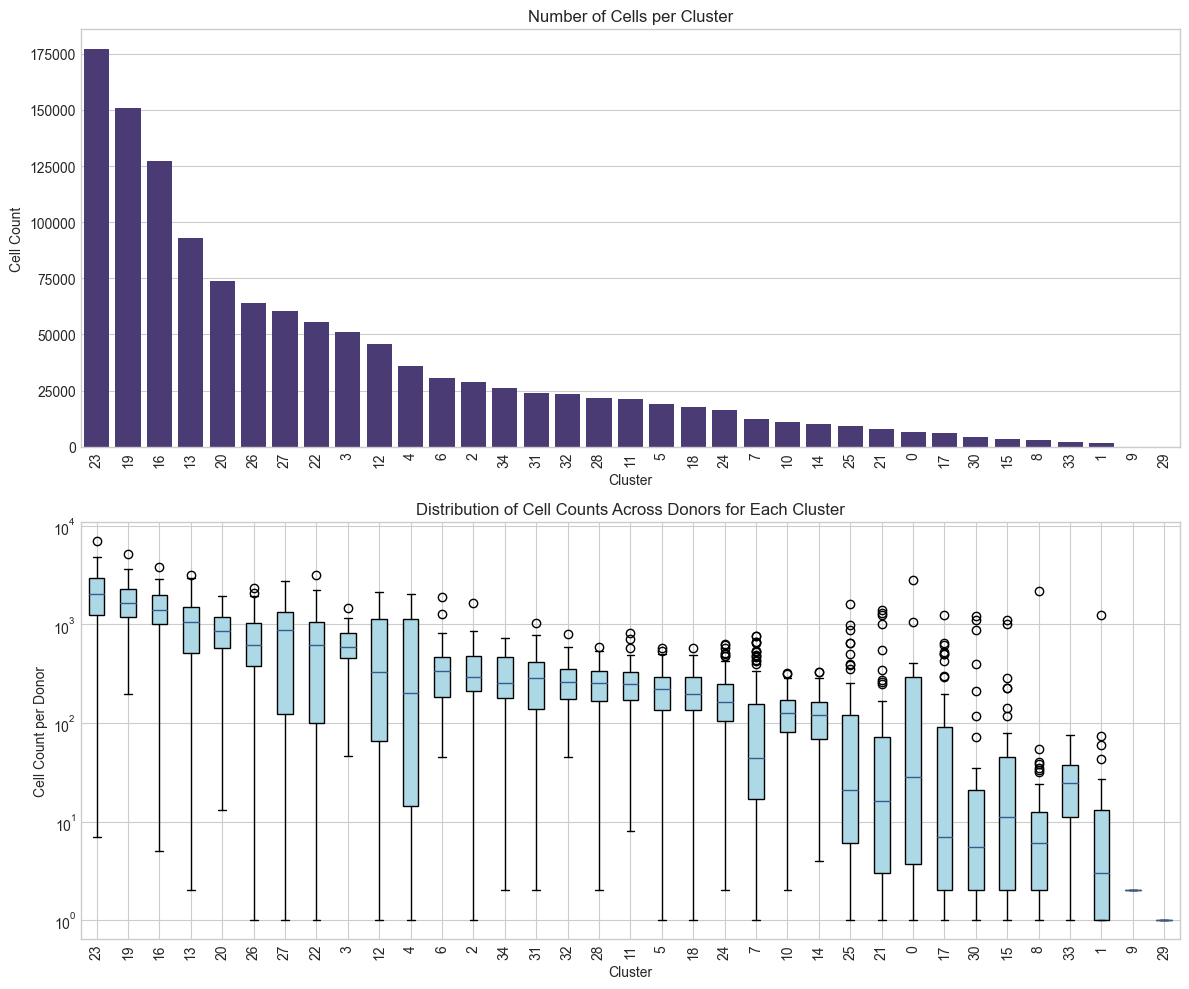


Analyzing clusters by cognitive status...

Cluster distribution by cognitive status:
Cognitive Status  Dementia  No dementia  Dementia %  No dementia %
cluster                                                           
0                      609         5954    0.113448       0.845619
1                     1395          195    0.259869       0.027695
10                    5100         5726    0.950060       0.813237
11                    9263        12165    1.725570       1.727738
12                   14917        30978    2.778833       4.399659
13                   33062        60093    6.158999       8.534725
14                    4582         5707    0.853564       0.810538
15                    3418          102    0.636727       0.014487
16                   51760        75383    9.642181      10.706292
17                    4220         1807    0.786128       0.256640


<Figure size 1200x600 with 0 Axes>

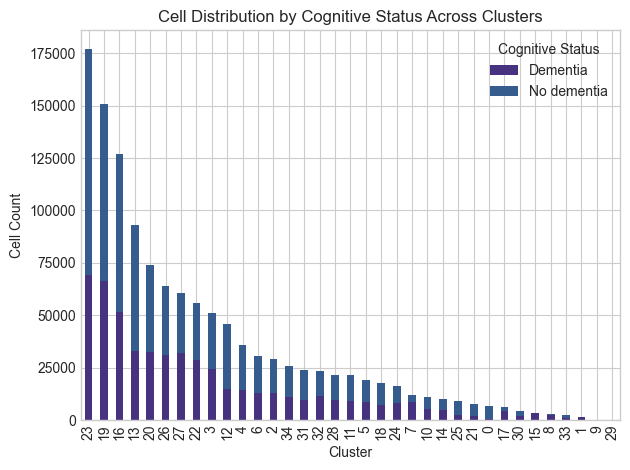


Dementia vs. No Dementia Comparison:
  cluster  Dementia  No_dementia  Dementia_to_No_dementia_ratio
0      15      3418          102                      33.509804
1       8      2439          326                       7.481595
2       1      1395          195                       7.153846
3       7      8705         3484                       2.498565
4      17      4220         1807                       2.335362
5      27     31916        28552                       1.117820
6      22     28874        26741                       1.079765
7      24      8149         8331                       0.978154
8      32     11500        11969                       0.960815
9      26     31121        32719                       0.951160


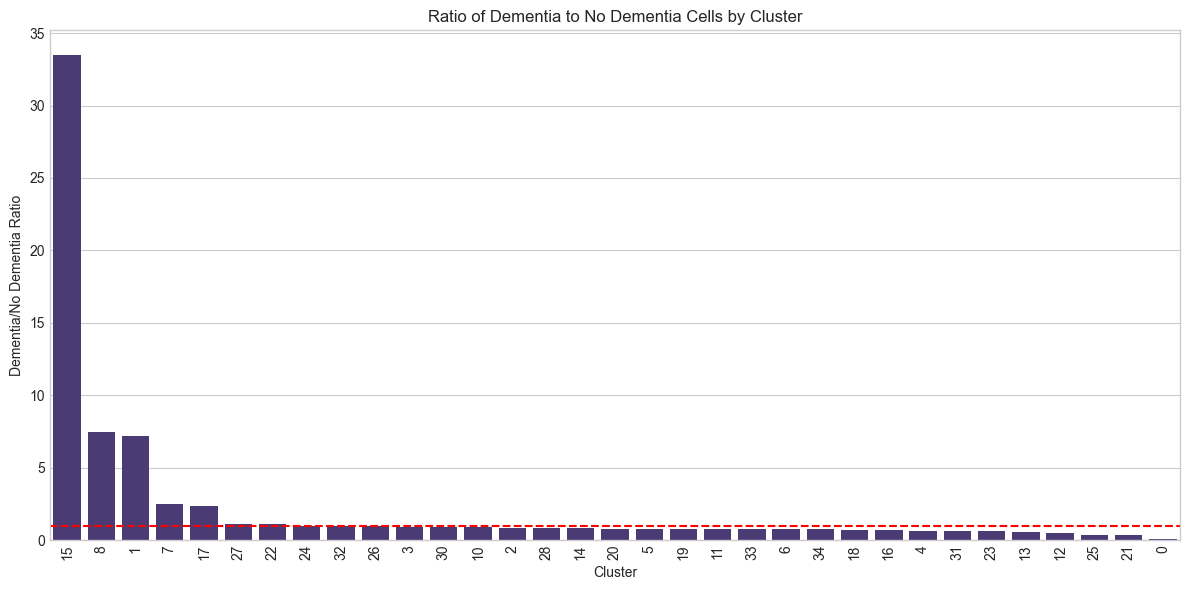

<Figure size 1000x800 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_cluster_distribution(cluster_df):
    """
    Analyze and visualize the distribution of cells across clusters with comparison
    between dementia and no dementia groups.
    
    Parameters:
    -----------
    cluster_df : pandas.DataFrame
        DataFrame containing cluster assignments from label_dataset_with_clusters
        
    Returns:
    --------
    summary_df : pandas.DataFrame
        Summary statistics about cluster distributions
    """
    print("Analyzing cluster distribution...")
    
    # Ensure required columns exist
    required_columns = ['Donor ID', 'cluster', 'cell_count']
    for col in required_columns:
        if col not in cluster_df.columns:
            raise ValueError(f"Required column '{col}' not found in the DataFrame")
    
    # Get total counts per cluster
    cluster_counts = cluster_df.groupby('cluster')['cell_count'].sum().reset_index()
    cluster_counts = cluster_counts.sort_values('cell_count', ascending=False)
    
    # Calculate percentage of total cells
    total_cells = cluster_counts['cell_count'].sum()
    cluster_counts['percent_of_total'] = (cluster_counts['cell_count'] / total_cells) * 100
    
    # Count donors per cluster
    donors_per_cluster = cluster_df.groupby('cluster')['Donor ID'].nunique().reset_index()
    donors_per_cluster.columns = ['cluster', 'number_of_donors']
    
    # Merge counts and donors
    summary_df = pd.merge(cluster_counts, donors_per_cluster, on='cluster')
    
    # Calculate average cells per donor for each cluster
    summary_df['avg_cells_per_donor'] = summary_df['cell_count'] / summary_df['number_of_donors']
    
    # Print summary
    print("\nCluster Distribution Summary:")
    print(f"Total cells: {total_cells}")
    print(f"Number of clusters: {len(summary_df)}")
    print("\nTop 5 clusters by cell count:")
    print(summary_df.head(5).to_string(index=False))
    
    # Create visualizations
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Bar chart of cell counts by cluster
    plt.subplot(2, 1, 1)
    sns.barplot(x='cluster', y='cell_count', data=summary_df, order=summary_df.sort_values('cell_count', ascending=False)['cluster'])
    plt.title('Number of Cells per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Cell Count')
    plt.xticks(rotation=90)
    
    # Plot 2: Distribution of cell counts across donors for each cluster
    plt.subplot(2, 1, 2)
    
    # Create a box plot showing distribution of cells per donor for each cluster
    cluster_donor_counts = cluster_df.pivot_table(
        index='cluster', 
        columns='Donor ID', 
        values='cell_count', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Reshape for box plot
    cluster_donor_data = []
    for cluster in summary_df.sort_values('cell_count', ascending=False)['cluster']:
        if cluster in cluster_donor_counts.index:
            values = cluster_donor_counts.loc[cluster].values
            values = values[values > 0]  # Only include donors that have cells in this cluster
            cluster_donor_data.append({
                'cluster': cluster,
                'values': values
            })
    
    # Create the box plot
    box_positions = np.arange(len(cluster_donor_data))
    
    plt.boxplot([item['values'] for item in cluster_donor_data], 
                positions=box_positions, 
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
    
    plt.xticks(box_positions, [item['cluster'] for item in cluster_donor_data], rotation=90)
    plt.title('Distribution of Cell Counts Across Donors for Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Cell Count per Donor')
    plt.yscale('log')  # Log scale often helps visualize distributions with wide ranges
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=300)
    plt.show()
    
    # Additional analysis based on cognitive status if available
    if 'Cognitive Status' in cluster_df.columns:
        print("\nAnalyzing clusters by cognitive status...")
        
        # Ensure we have dementia status data to work with
        status_counts = cluster_df.groupby(['cluster', 'Cognitive Status'])['cell_count'].sum().reset_index()
        
        # Check if we have both dementia and no dementia statuses
        statuses = status_counts['Cognitive Status'].unique()
        has_dementia_comparison = ('Dementia' in statuses and 'No dementia' in statuses)
        
        if len(statuses) > 0:
            # Create pivot table
            status_pivot = status_counts.pivot_table(
                index='cluster',
                columns='Cognitive Status',
                values='cell_count',
                fill_value=0
            )
            
            # Calculate percentage within each status
            for status in status_pivot.columns:
                status_total = status_pivot[status].sum()
                status_pivot[f'{status} %'] = (status_pivot[status] / status_total) * 100
            
            print("\nCluster distribution by cognitive status:")
            print(status_pivot.head(10))
            
            # Create a stacked bar chart
            plt.figure(figsize=(12, 6))
            
            # Get columns that aren't percentage columns
            non_pct_cols = [col for col in status_pivot.columns if not col.endswith('%')]
            if non_pct_cols:  # Make sure we have data columns
                status_pivot_plot = status_pivot[non_pct_cols].copy()
                
                # Sort by total cell count across all statuses
                row_sums = status_pivot_plot.sum(axis=1)
                status_pivot_plot = status_pivot_plot.loc[row_sums.sort_values(ascending=False).index]
                
                status_pivot_plot.plot(kind='bar', stacked=True)
                plt.title('Cell Distribution by Cognitive Status Across Clusters')
                plt.xlabel('Cluster')
                plt.ylabel('Cell Count')
                plt.xticks(rotation=90)
                plt.tight_layout()
                plt.savefig('cluster_by_cognitive_status.png', dpi=300)
                plt.show()
            
            # If we have both dementia and no dementia, create comparison plots
            if has_dementia_comparison:
                # Create comparison dataframe for dementia vs. no dementia
                comparison_df = pd.DataFrame({
                    'cluster': status_pivot.index,
                    'Dementia': status_pivot.get('Dementia', 0),
                    'No_dementia': status_pivot.get('No dementia', 0)
                })
                
                # Calculate ratio (Dementia / No dementia)
                comparison_df['Dementia_to_No_dementia_ratio'] = comparison_df['Dementia'] / comparison_df['No_dementia'].replace(0, np.nan)
                
                # Sort by ratio for visualization
                comparison_df = comparison_df.sort_values('Dementia_to_No_dementia_ratio', ascending=False).reset_index(drop=True)
                
                # Drop rows with NaN ratios (no 'No dementia' cells)
                comparison_df = comparison_df.dropna(subset=['Dementia_to_No_dementia_ratio'])
                
                # Print comparison summary
                print("\nDementia vs. No Dementia Comparison:")
                print(comparison_df.head(10))
                
                # Create ratio visualization
                plt.figure(figsize=(12, 6))
                sns.barplot(x='cluster', y='Dementia_to_No_dementia_ratio', data=comparison_df)
                plt.title('Ratio of Dementia to No Dementia Cells by Cluster')
                plt.xlabel('Cluster')
                plt.ylabel('Dementia/No Dementia Ratio')
                plt.xticks(rotation=90)
                plt.axhline(y=1, color='r', linestyle='--')  # Add reference line at ratio=1
                plt.tight_layout()
                plt.savefig('dementia_vs_no_dementia_ratio.png', dpi=300)
                plt.show()
                
                # Create enrichment heatmap - which clusters are enriched in which condition
                plt.figure(figsize=(10, 8))
                
                # Calculate percentages within each cognitive status
                enrichment_data = status_pivot.copy()
                
                # Calculate percentages
                dementia_total = enrichment_data.get('Dementia', 0).sum()
                no_dementia_total = enrichment_data.get('No dementia', 0).sum()
                
                if dementia_total > 0 and no_dementia_total > 0:
                    enrichment_data['Dementia_pct'] = enrichment_data.get('Dementia', 0) / dementia_total * 100
                    enrichment_data['No_dementia_pct'] = enrichment_data.get('No dementia', 0) / no_dementia_total * 100
                    
                    # Calculate log2 fold change
                    enrichment_data['log2FC'] = np.log2((enrichment_data['Dementia_pct'] + 0.1) / 
                                                        (enrichment_data['No_dementia_pct'] + 0.1))
                    
                    # Sort by log2FC
                    enrichment_data = enrichment_data.sort_values('log2FC', ascending=False)
                    
               
                    # Add enrichment data to summary_df
                    enrichment_info = enrichment_data[['Dementia_pct', 'No_dementia_pct', 'log2FC']]
                    summary_df = pd.merge(summary_df, enrichment_info, left_on='cluster', right_index=True, how='left')
    
    return summary_df

# Example usage:

summary = analyze_cluster_distribution(cluster_expr_df)

Analyzing cluster distribution...

Cluster Distribution Summary:
Total cells: 1240908
Number of clusters: 35

Top 5 clusters by cell count:
cluster  cell_count  percent_of_total  number_of_donors  avg_cells_per_donor
     23      177015         14.264958                83          2132.710843
     19      150839         12.155534                84          1795.702381
     16      127143         10.245965                84          1513.607143
     13       93155          7.507003                84          1108.988095
     20       73771          5.944921                84           878.226190


/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_38601/2688823820.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


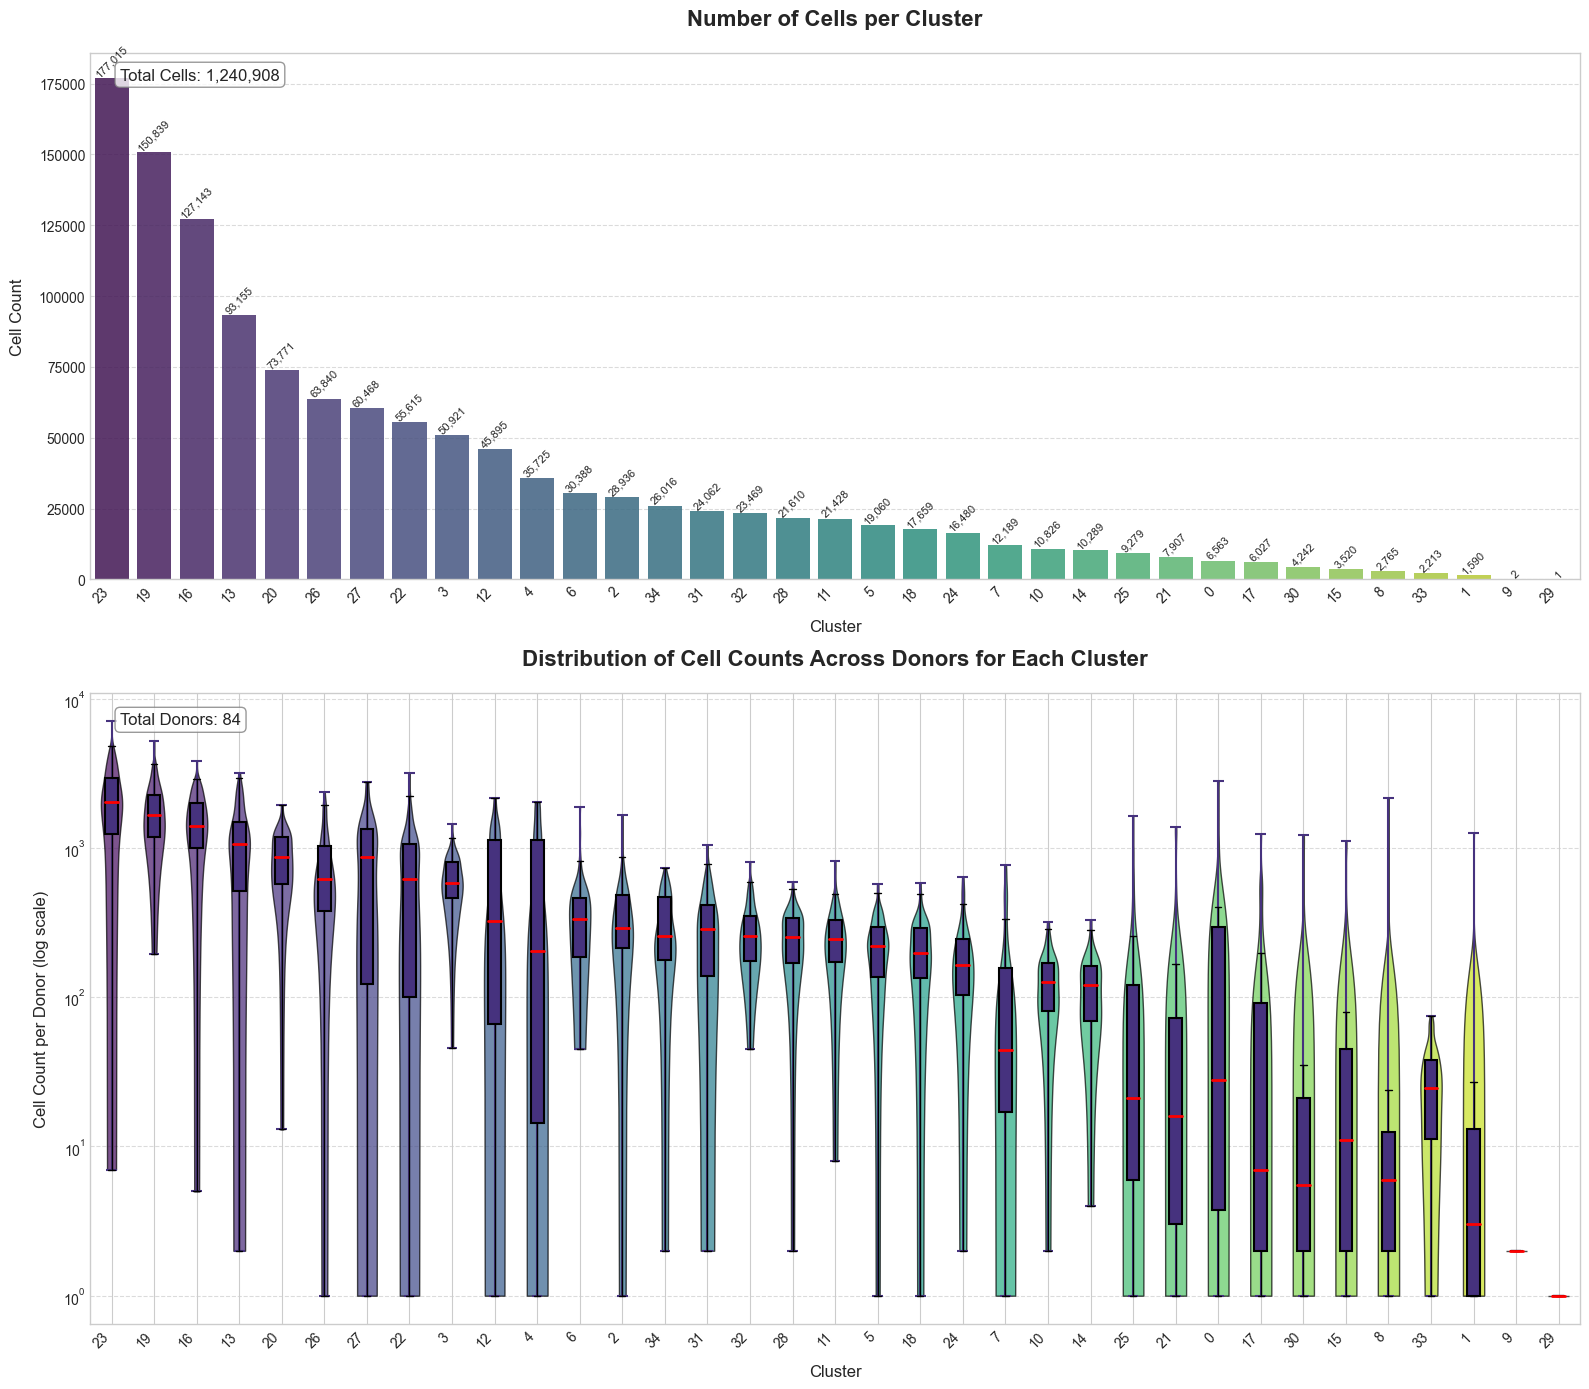


Analyzing clusters by cognitive status...

Cluster distribution by cognitive status:
Cognitive Status  Dementia  No dementia  Dementia %  No dementia %
cluster                                                           
0                      609         5954    0.113448       0.845619
1                     1395          195    0.259869       0.027695
10                    5100         5726    0.950060       0.813237
11                    9263        12165    1.725570       1.727738
12                   14917        30978    2.778833       4.399659
13                   33062        60093    6.158999       8.534725
14                    4582         5707    0.853564       0.810538
15                    3418          102    0.636727       0.014487
16                   51760        75383    9.642181      10.706292
17                    4220         1807    0.786128       0.256640


<Figure size 1400x800 with 0 Axes>

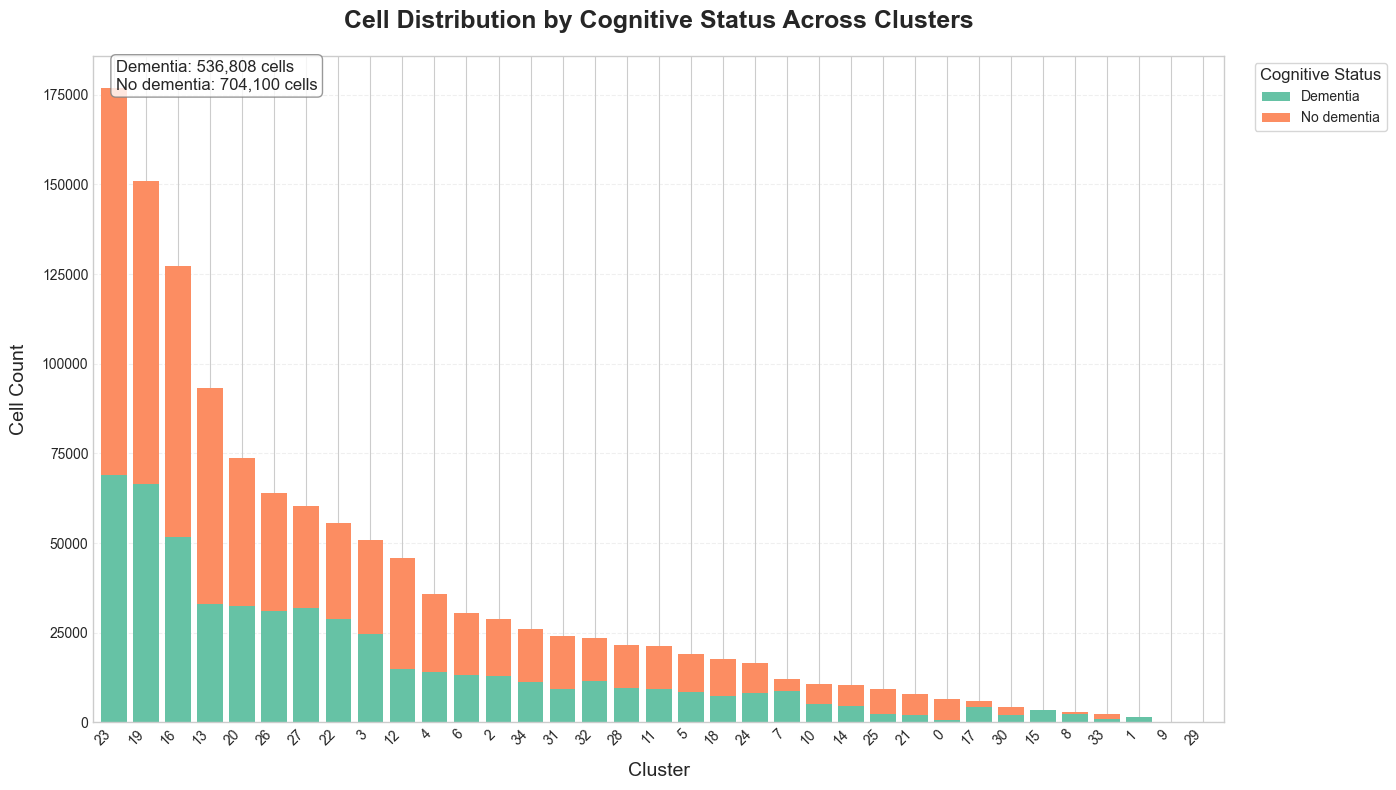


Dementia vs. No Dementia Comparison:
  cluster  Dementia  No_dementia  Dementia_to_No_dementia_ratio
0      15      3418          102                      33.509804
1       8      2439          326                       7.481595
2       1      1395          195                       7.153846
3       7      8705         3484                       2.498565
4      17      4220         1807                       2.335362
5      27     31916        28552                       1.117820
6      22     28874        26741                       1.079765
7      24      8149         8331                       0.978154
8      32     11500        11969                       0.960815
9      26     31121        32719                       0.951160


/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_38601/2688823820.py:379: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


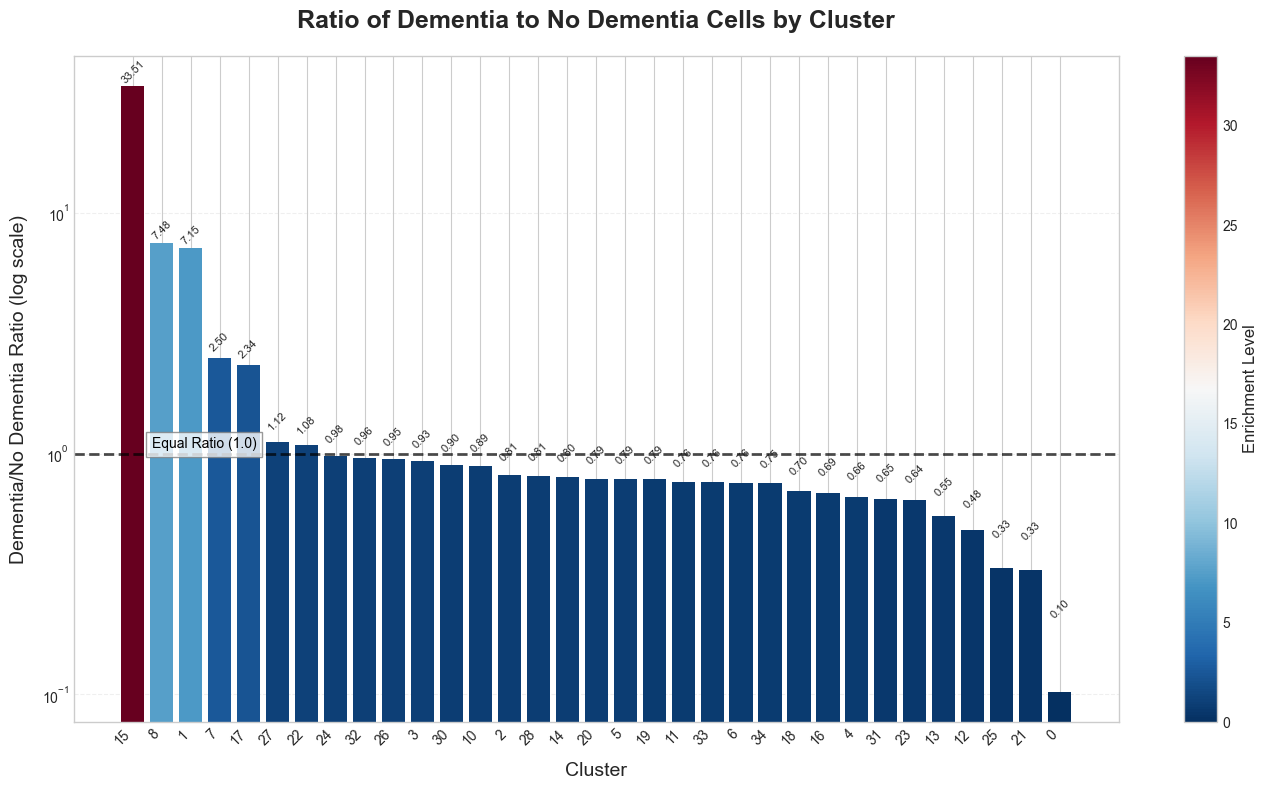

<Figure size 1400x1000 with 0 Axes>

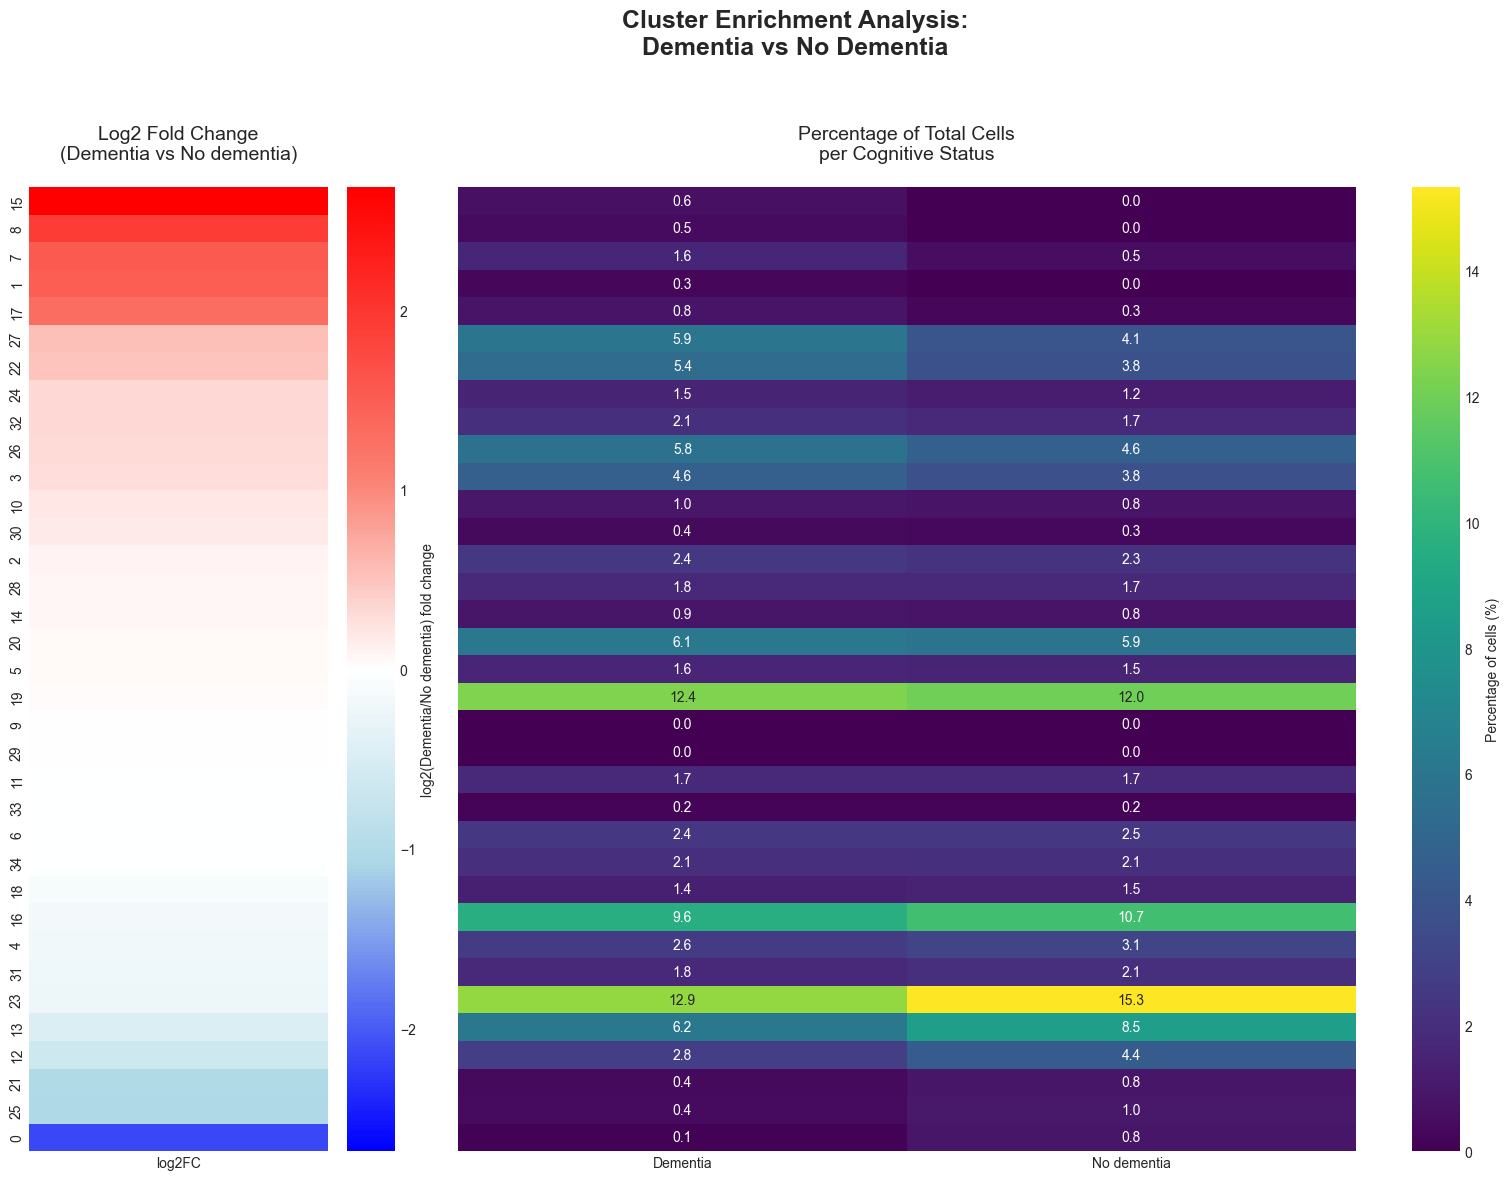

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Set the style for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def analyze_cluster_distribution(cluster_df):
    """
    Analyze and visualize the distribution of cells across clusters with comparison
    between dementia and no dementia groups.
    
    Parameters:
    -----------
    cluster_df : pandas.DataFrame
        DataFrame containing cluster assignments from label_dataset_with_clusters
        
    Returns:
    --------
    summary_df : pandas.DataFrame
        Summary statistics about cluster distributions
    """
    print("Analyzing cluster distribution...")
    
    # Ensure required columns exist
    required_columns = ['Donor ID', 'cluster', 'cell_count']
    for col in required_columns:
        if col not in cluster_df.columns:
            raise ValueError(f"Required column '{col}' not found in the DataFrame")
    
    # Get total counts per cluster
    cluster_counts = cluster_df.groupby('cluster')['cell_count'].sum().reset_index()
    cluster_counts = cluster_counts.sort_values('cell_count', ascending=False)
    
    # Calculate percentage of total cells
    total_cells = cluster_counts['cell_count'].sum()
    cluster_counts['percent_of_total'] = (cluster_counts['cell_count'] / total_cells) * 100
    
    # Count donors per cluster
    donors_per_cluster = cluster_df.groupby('cluster')['Donor ID'].nunique().reset_index()
    donors_per_cluster.columns = ['cluster', 'number_of_donors']
    
    # Merge counts and donors
    summary_df = pd.merge(cluster_counts, donors_per_cluster, on='cluster')
    
    # Calculate average cells per donor for each cluster
    summary_df['avg_cells_per_donor'] = summary_df['cell_count'] / summary_df['number_of_donors']
    
    # Print summary
    print("\nCluster Distribution Summary:")
    print(f"Total cells: {total_cells}")
    print(f"Number of clusters: {len(summary_df)}")
    print("\nTop 5 clusters by cell count:")
    print(summary_df.head(5).to_string(index=False))
    
    # Create visualizations with improved layout and styling
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.2])
    
    # Define a custom color palette - using a gradient from dark blue to teal
    cluster_palette = sns.color_palette("viridis", n_colors=len(summary_df))
    
    # Plot 1: Bar chart of cell counts by cluster with improved styling
    ax1 = plt.subplot(gs[0])
    
    # Sort clusters by cell count
    ordered_clusters = summary_df.sort_values('cell_count', ascending=False)
    
    # Create the bar plot with the custom palette
    bars = sns.barplot(
        x='cluster', 
        y='cell_count', 
        data=ordered_clusters,
        ax=ax1,
        palette=cluster_palette,
        alpha=0.85
    )
    
    # Add count labels on top of each bar
    for i, bar in enumerate(bars.patches):
        bars.annotate(
            format(ordered_clusters.iloc[i]['cell_count'], ','),
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=45
        )
    
    # Improve title and labels
    ax1.set_title('Number of Cells per Cluster', fontsize=16, pad=20, fontweight='bold')
    ax1.set_xlabel('Cluster', fontsize=12, labelpad=10)
    ax1.set_ylabel('Cell Count', fontsize=12, labelpad=10)
    
    # Improve x-tick styling
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    
    # Add a grid for easier reading of values
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotation with total cell count
    ax1.annotate(
        f'Total Cells: {total_cells:,}',
        xy=(0.02, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Plot 2: Distribution of cell counts across donors for each cluster
    ax2 = plt.subplot(gs[1])
    
    # Create a box plot showing distribution of cells per donor for each cluster
    cluster_donor_counts = cluster_df.pivot_table(
        index='cluster', 
        columns='Donor ID', 
        values='cell_count', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Reshape for box plot
    cluster_donor_data = []
    for cluster in ordered_clusters['cluster']:
        if cluster in cluster_donor_counts.index:
            values = cluster_donor_counts.loc[cluster].values
            values = values[values > 0]  # Only include donors that have cells in this cluster
            cluster_donor_data.append({
                'cluster': cluster,
                'values': values
            })
    
    # Create the box plot with custom styling
    box_positions = np.arange(len(cluster_donor_data))
    
    # Create violin plots instead of simple boxplots for more detailed distribution visualization
    parts = ax2.violinplot(
        [item['values'] for item in cluster_donor_data],
        positions=box_positions,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )
    
    # Color the violin plots to match the bar chart colors
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(cluster_palette[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    # Style the median lines
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linewidth(1.5)
    
    # Add a boxplot overlay for clearer quartile visualization
    boxprops = dict(linestyle='-', linewidth=1.5, color='black')
    whiskerprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='-', linewidth=2, color='red')
    
    ax2.boxplot(
        [item['values'] for item in cluster_donor_data],
        positions=box_positions,
        widths=0.3,
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        medianprops=medianprops,
        showfliers=False
    )
    
    # Set the x-axis ticks and labels
    ax2.set_xticks(box_positions)
    ax2.set_xticklabels([item['cluster'] for item in cluster_donor_data], rotation=45, ha='right', fontsize=10)
    
    # Improve title and labels
    ax2.set_title('Distribution of Cell Counts Across Donors for Each Cluster', fontsize=16, pad=20, fontweight='bold')
    ax2.set_xlabel('Cluster', fontsize=12, labelpad=10)
    ax2.set_ylabel('Cell Count per Donor (log scale)', fontsize=12, labelpad=10)
    
    # Use log scale for better visualization of distributions with wide ranges
    ax2.set_yscale('log')
    
    # Add grid lines for easier reading
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotation with number of donors
    ax2.annotate(
        f'Total Donors: {cluster_df["Donor ID"].nunique()}',
        xy=(0.02, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional analysis based on cognitive status if available
    if 'Cognitive Status' in cluster_df.columns:
        print("\nAnalyzing clusters by cognitive status...")
        
        # Ensure we have dementia status data to work with
        status_counts = cluster_df.groupby(['cluster', 'Cognitive Status'])['cell_count'].sum().reset_index()
        
        # Check if we have both dementia and no dementia statuses
        statuses = status_counts['Cognitive Status'].unique()
        has_dementia_comparison = ('Dementia' in statuses and 'No dementia' in statuses)
        
        if len(statuses) > 0:
            # Create pivot table
            status_pivot = status_counts.pivot_table(
                index='cluster',
                columns='Cognitive Status',
                values='cell_count',
                fill_value=0
            )
            
            # Calculate percentage within each status
            for status in status_pivot.columns:
                status_total = status_pivot[status].sum()
                status_pivot[f'{status} %'] = (status_pivot[status] / status_total) * 100
            
            print("\nCluster distribution by cognitive status:")
            print(status_pivot.head(10))
            
            # Create a stacked bar chart with improved styling
            plt.figure(figsize=(14, 8))
            
            # Get columns that aren't percentage columns
            non_pct_cols = [col for col in status_pivot.columns if not col.endswith('%')]
            
            if non_pct_cols:  # Make sure we have data columns
                status_pivot_plot = status_pivot[non_pct_cols].copy()
                
                # Sort by total cell count across all statuses
                row_sums = status_pivot_plot.sum(axis=1)
                status_pivot_plot = status_pivot_plot.loc[row_sums.sort_values(ascending=False).index]
                
                # Use a color-blind friendly palette
                colors = sns.color_palette("Set2", len(non_pct_cols))
                
                # Create stacked bar chart
                ax = status_pivot_plot.plot(
                    kind='bar', 
                    stacked=True, 
                    figsize=(14, 8),
                    color=colors,
                    width=0.8
                )
                
                # Improve title and labels
                plt.title('Cell Distribution by Cognitive Status Across Clusters', fontsize=18, pad=20, fontweight='bold')
                plt.xlabel('Cluster', fontsize=14, labelpad=10)
                plt.ylabel('Cell Count', fontsize=14, labelpad=10)
                
                # Improve legend
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(
                    handles, 
                    labels, 
                    title='Cognitive Status',
                    title_fontsize=12,
                    fontsize=10,
                    loc='upper right',
                    bbox_to_anchor=(1.15, 1),
                    frameon=True,
                    facecolor='white'
                )
                
                # Improve x-tick styling
                plt.xticks(rotation=45, ha='right', fontsize=10)
                
                # Add a grid for better readability
                ax.grid(axis='y', linestyle='--', alpha=0.3)
                
                # Add annotation with totals
                total_dementia = status_pivot_plot.get('Dementia', 0).sum() if 'Dementia' in status_pivot_plot.columns else 0
                total_no_dementia = status_pivot_plot.get('No dementia', 0).sum() if 'No dementia' in status_pivot_plot.columns else 0
                
                if 'Dementia' in status_pivot_plot.columns and 'No dementia' in status_pivot_plot.columns:
                    plt.annotate(
                        f'Dementia: {total_dementia:,} cells\nNo dementia: {total_no_dementia:,} cells',
                        xy=(0.02, 0.95),
                        xycoords='axes fraction',
                        fontsize=12,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                    )
                
                plt.tight_layout()
                plt.savefig('cluster_by_cognitive_status.png', dpi=300, bbox_inches='tight')
                plt.show()
            
            # If we have both dementia and no dementia, create comparison plots
            if has_dementia_comparison:
                # Create comparison dataframe for dementia vs. no dementia
                comparison_df = pd.DataFrame({
                    'cluster': status_pivot.index,
                    'Dementia': status_pivot.get('Dementia', 0),
                    'No_dementia': status_pivot.get('No dementia', 0)
                })
                
                # Calculate ratio (Dementia / No dementia)
                comparison_df['Dementia_to_No_dementia_ratio'] = comparison_df['Dementia'] / comparison_df['No_dementia'].replace(0, np.nan)
                
                # Sort by ratio for visualization
                comparison_df = comparison_df.sort_values('Dementia_to_No_dementia_ratio', ascending=False).reset_index(drop=True)
                
                # Drop rows with NaN ratios (no 'No dementia' cells)
                comparison_df = comparison_df.dropna(subset=['Dementia_to_No_dementia_ratio'])
                
                # Print comparison summary
                print("\nDementia vs. No Dementia Comparison:")
                print(comparison_df.head(10))
                
                # Create ratio visualization with improved styling
                plt.figure(figsize=(14, 8))
                
                # Create a diverging color palette centered at 1.0 (equal ratio)
                ratio_values = comparison_df['Dementia_to_No_dementia_ratio'].values
                max_ratio = max(np.max(ratio_values), 1/np.min(ratio_values[ratio_values > 0]))
                norm = plt.Normalize(0, max_ratio)
                
                # Create bar plot
                bars = plt.bar(
                    comparison_df['cluster'], 
                    comparison_df['Dementia_to_No_dementia_ratio'],
                    color=plt.cm.RdBu_r(norm(comparison_df['Dementia_to_No_dementia_ratio']))
                )
                
                # Add ratio labels on top of each bar
                for bar in bars:
                    height = bar.get_height()
                    plt.text(
                        bar.get_x() + bar.get_width()/2., 
                        height + 0.1,
                        f'{height:.2f}',
                        ha='center', 
                        va='bottom',
                        rotation=45,
                        fontsize=8
                    )
                
                # Improve title and labels
                plt.title('Ratio of Dementia to No Dementia Cells by Cluster', fontsize=18, pad=20, fontweight='bold')
                plt.xlabel('Cluster', fontsize=14, labelpad=10)
                plt.ylabel('Dementia/No Dementia Ratio (log scale)', fontsize=14, labelpad=10)
                
                # Add reference line at ratio=1 (equal representation)
                plt.axhline(y=1, color='k', linestyle='--', alpha=0.7, linewidth=2)
                
                # Add text annotation for the reference line
                plt.text(
                    len(comparison_df) * 0.02, 
                    1.05, 
                    'Equal Ratio (1.0)',
                    fontsize=10,
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                )
                
                # Use log scale for better visualization
                plt.yscale('log')
                
                # Improve x-tick styling
                plt.xticks(rotation=45, ha='right', fontsize=10)
                
                # Add a grid for better readability
                plt.grid(axis='y', linestyle='--', alpha=0.3)
                
                # Add colorbar legend for ratio values
                sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm)
                cbar.set_label('Enrichment Level', fontsize=12)
                
                plt.tight_layout()
                plt.savefig('dementia_vs_no_dementia_ratio.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # Create enrichment heatmap with improved styling
                plt.figure(figsize=(14, 10))
                
                # Calculate percentages within each cognitive status
                enrichment_data = status_pivot.copy()
                
                # Calculate percentages
                dementia_total = enrichment_data.get('Dementia', 0).sum()
                no_dementia_total = enrichment_data.get('No dementia', 0).sum()
                
                if dementia_total > 0 and no_dementia_total > 0:
                    enrichment_data['Dementia_pct'] = enrichment_data.get('Dementia', 0) / dementia_total * 100
                    enrichment_data['No_dementia_pct'] = enrichment_data.get('No dementia', 0) / no_dementia_total * 100
                    
                    # Calculate log2 fold change
                    enrichment_data['log2FC'] = np.log2((enrichment_data['Dementia_pct'] + 0.1) / 
                                                        (enrichment_data['No_dementia_pct'] + 0.1))
                    
                    # Sort by log2FC
                    enrichment_data = enrichment_data.sort_values('log2FC', ascending=False)
                    
                    # Create heatmap data
                    heatmap_data = pd.DataFrame({
                        'cluster': enrichment_data.index,
                        'log2FC': enrichment_data['log2FC'],
                        'Dementia_pct': enrichment_data['Dementia_pct'],
                        'No_dementia_pct': enrichment_data['No_dementia_pct']
                    })
                    
                    # Create a figure with subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw={'width_ratios': [1, 3]})
                    
                    # Create a custom diverging colormap for the log2FC
                    colors = ['blue', 'lightblue', 'white', 'salmon', 'red']
                    positions = [0, 0.3, 0.5, 0.7, 1]
                    cmap = LinearSegmentedColormap.from_list('custom_diverging', list(zip(positions, colors)))
                    
                    # 1. Log2FC heatmap
                    # Find the maximum absolute value for symmetric color scale
                    max_abs_fc = max(abs(heatmap_data['log2FC'].min()), abs(heatmap_data['log2FC'].max()))
                    vmin, vmax = -max_abs_fc, max_abs_fc
                    
                    sns.heatmap(
                        heatmap_data['log2FC'].values.reshape(-1, 1),
                        ax=ax1,
                        cmap=cmap,
                        vmin=vmin, 
                        vmax=vmax,
                        cbar_kws={'label': 'log2(Dementia/No dementia) fold change'},
                        yticklabels=heatmap_data['cluster'],
                        xticklabels=['log2FC']
                    )
                    
                    ax1.set_title('Log2 Fold Change\n(Dementia vs No dementia)', fontsize=14, pad=20)
                    ax1.set_ylabel('')
                    
                    # 2. Percentage representation heatmap
                    percentage_data = heatmap_data[['Dementia_pct', 'No_dementia_pct']]
                    
                    sns.heatmap(
                        percentage_data.values,
                        ax=ax2,
                        cmap='viridis',
                        cbar_kws={'label': 'Percentage of cells (%)'},
                        yticklabels=False,
                        xticklabels=['Dementia', 'No dementia'],
                        annot=True,
                        fmt='.1f'
                    )
                    
                    ax2.set_title('Percentage of Total Cells\nper Cognitive Status', fontsize=14, pad=20)
                    
                    # Improve overall figure
                    plt.suptitle('Cluster Enrichment Analysis:\nDementia vs No Dementia', fontsize=18, y=0.98, fontweight='bold')
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.savefig('dementia_enrichment_heatmap.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    # Add enrichment data to summary_df
                    enrichment_info = enrichment_data[['Dementia_pct', 'No_dementia_pct', 'log2FC']]
                    summary_df = pd.merge(summary_df, enrichment_info, left_on='cluster', right_index=True, how='left')
    
    return summary_df

# Example usage:

summary = analyze_cluster_distribution(cluster_expr_df)